# This script generates snow components for different snow products

In [6]:
from netCDF4 import Dataset
import pickle
import xarray as xr
from cartoplot import cartoplot
import mask
from field_importer import get_field
from scipy.interpolate import NearestNDInterpolator
import scipy.interpolate
from field_importer import get_field
import numpy.ma as ma
from select_type import select_type
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import trange
from regrid import regrid

In [7]:
yearlist = list(range(2002,2019))
print(yearlist)

monthlist_full = ["01","02","03","04","10","11","12"]
monthlist_end = ["01","02","03","04"]
monthlist_start = ["10","11","12"]

[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


# Calculate components

In [8]:
resolution = (361,361)
snow_factor = 0.001813

def components():
    
    for year in yearlist:

        print(year)

        if year == 2002:
            monthlist = monthlist_start
        elif year == 2018:
            monthlist = monthlist_end
        else:
            monthlist = monthlist_full
        
        nan_array = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
        
        mW99_conts = nan_array.copy()
        SM_conts = nan_array.copy()
        M2_conts = nan_array.copy()
        E5_conts = nan_array.copy()
        NS_conts = nan_array.copy()
        freeboard_conts = nan_array.copy()
        types = nan_array.copy()

        for counter, month in enumerate(monthlist):

            
            mW99_SWE = get_field('mW99',month,year,resolution=361,variable='SWE')['field']
                
            SM_SWE = get_field('SnowModel',month,year,resolution=361,variable='SWE')['field']
            M2_SWE = get_field('SnowModel',month,year,resolution=361,variable='M2 SWE')['field']
            E5_SWE = get_field('SnowModel',month,year,resolution=361,variable='E5 SWE')['field']
            
            if (year < 2015) or (year == 2015 and int(month) < 5):
                NS_SWE = get_field('nesosim',month,year,resolution=361,variable='swe')['field']
                
            if int(year) < 2005:
                type_type = 'cds'
            elif (int(year) == 2005) and (int(month) < 6):
                type_type = 'cds'
            else:
                type_type = 'osisaf'
                
        
            if int(year) < 2010:
                radar_type = 'cci_envisat'
            elif (int(year) == 2010) and (int(month)<11):
                radar_type = 'cci_envisat'
            elif int(year) < 2017:
                radar_type = 'cci_cs2'
            elif (int(year) == 2017) and (int(month) < 5):
                radar_type = 'cci_cs2'
            else:
                radar_type = 'landy'
                
            ice_type = get_field(type_type,month,year,resolution=361,variable='type')['field']
            
            radar_freeboard_data = get_field(radar_type,month,year,resolution=361,variable='rad')
            
            if radar_type != 'landy':
                
                radar_freeboards = regrid(radar_freeboard_data['field'],
                                           radar_freeboard_data['lon'],
                                           radar_freeboard_data['lat'],
                                           mask.get('lon'),
                                           mask.get('lat'),
                                           )
            
            ########################################################################
            
            # Make mW99 contribution
            
            rho_w   = 1023.9
            rho_fyi = 916.7
            rho_myi = 882
            
            nans_everywhere = np.full(  (resolution), np.nan)
            
            MYI_masked = ma.masked_where(ice_type == 3, nans_everywhere)
            MYI_masked = np.ma.filled(MYI_masked.astype(float), rho_myi)

            FYI_masked = ma.masked_where(ice_type == 2, MYI_masked)
            density_field = np.ma.filled(FYI_masked.astype(float), rho_fyi)
            
            hydro_coeff_field = np.divide(rho_w, np.subtract(rho_w,density_field))

            snow_coeff_field = np.multiply(snow_factor,hydro_coeff_field)

            mW99_conts[counter] = np.multiply(mW99_SWE, snow_coeff_field)
            
            #####################################################################################
            
            # Make SM contribution
            
            SM_conts[counter] = np.multiply(SM_SWE, snow_coeff_field)
            E5_conts[counter] = np.multiply(E5_SWE, snow_coeff_field)
            M2_conts[counter] = np.multiply(M2_SWE, snow_coeff_field)
            
            # Make NS contribution
            
            if (year < 2015) or (year == 2015 and int(month) < 5):
                NS_conts[counter] = np.multiply(NS_SWE, snow_coeff_field)
            
            ######################################################################################
            
            # Make Radar Freeboard Contribution
    
            temp_fb = np.multiply(hydro_coeff_field,radar_freeboards) 
        
            # Fix November 2009 RF anomaly in Barents Sea
        
            if (month == "11") and (year == 2009):
                mask_field = mask.get('mask')
                temp_fb = ma.masked_where(mask_field == 8, temp_fb)
                temp_fb = np.ma.filled(temp_fb.astype(float), np.nan)
                print('Fixed Barents 09/2009 coastal anomaly')
                
            freeboard_conts[counter] = temp_fb
            
            ######################################################################################
            
            # Save Ice Type
            
            types[counter] = ice_type
            
        # SAVE THE YEAR'S DATA AS NETCDF

        monthlist_ints = [int(month) for month in monthlist]
        
        data_vars = {'mW99':(['t','x','y'],mW99_conts),
                    'SM':(['t','x','y'],SM_conts),
                    'M2':(['t','x','y'],M2_conts),
                    'E5':(['t','x','y'],E5_conts),                     
                    'free':(['t','x','y'],freeboard_conts),
                    'type':(['t','x','y'],types)       }
        
        if year < 2016:
            data_vars['NS'] = (['t','x','y'],NS_conts)



        ds = xr.Dataset(data_vars = data_vars,
                        
                        coords={'lon':(['x','y'],mask.get('lon')),
                                 'lat':(['x','y'],mask.get('lat')),
                                 'month':(['t'],monthlist_ints)}    )

        data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/'

        ds.to_netcdf(f'{data_dir}{year}_components.nc','w')
        
components()

2002
2003
2004
2005
2006
2007
2008
2009
Fixed Barents 09/2009 coastal anomaly
2010
2011
2012
2013
2014
2015
2016
2017
2018


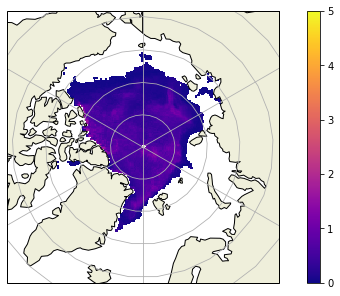

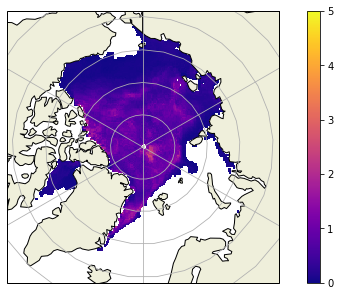

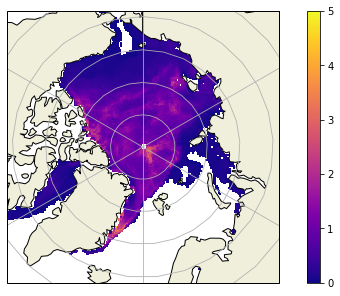

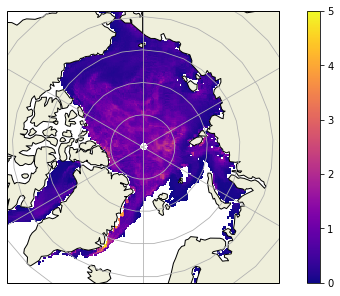

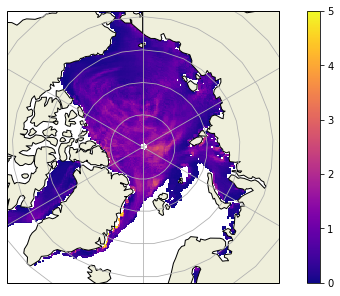

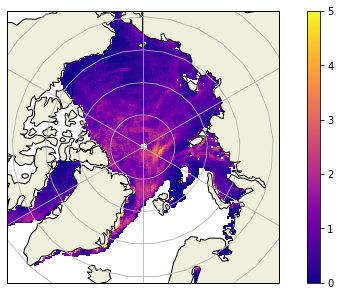

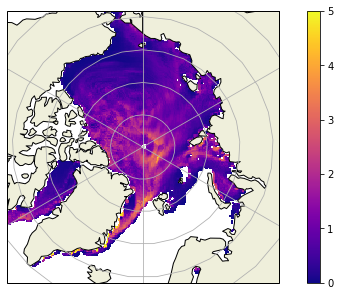

In [10]:
monthlist = ["10","11","12","01","02","03","04"]
year = 2016

dataset = 'SM'

for month in monthlist:
    
    data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/'

    with xr.open_dataset(f'{data_dir}{year}_components.nc') as data:

        ds_month = data.where(int(month) == data.month, drop=True)

    d = np.array(ds_month[dataset])[0]
    
    cartoplot(mask.get('lon'), mask.get('lat'), d, color_scale = (0,5))

# Test the dataset

/home/robbie/custom_modules/mask.py:77: RuntimeWarning: invalid value encountered in greater
  array = ma.masked_where(get('lat') > latitude, array)


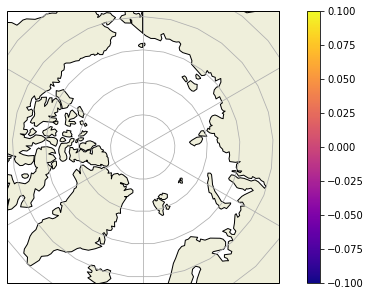

In [18]:
from regrid import regrid
from mask import select_region

lon = mask.get('lon')
lat = mask.get('lat')

# d = get_field('cci_envisat', month='11',year=2009,variable='rad')
# fb = d['field']
# lon = d['lon']
# lat = d['lat']
data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/'

with xr.open_dataset(f'{data_dir}2009_components.nc') as data:

    ds_month = data.where(int(11) == data.month, drop=True)

fb = np.array(ds_month['free'])[0]

fb_barents = select_region('Barents',fb)


cartoplot(lon,lat,fb_barents)

# cartoplot(lon,lat,fb_barents)

# print(np.nanmean(fb_barents))


# print(clean_fb_array)

# Calculate Offsets for W99

# Now test the W99 correction

In [ ]:
year = 2011

full_data = pickle.load(open("/home/robbie/Dropbox/GRL_Thickness/Corrections/"+str(year)+"_W99_corr.p","rb"))

fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='npstere',boundinglat=60,lon_0=360,resolution='l')
m.drawcoastlines(linewidth=0.5)

m.pcolormesh(Mask.get('lon'), Mask.get('lat'), full_data['03']['total_correction'], latlon=True,cmap='plasma')

plt.show()

# Finally, calculate the thickness difference between products

# Set the convention that differences are SM - W99

In [ ]:
for year in yearlist:
    
    print(year)
    
    year_data = {}
    
    if year == 2010:
        monthlist = monthlist_2010
    elif year == 2018:
        monthlist = monthlist_2018
    else:
        monthlist = monthlist_full
    
    for month in monthlist:
        
        mW99_data = pickle.load(open("../data/snow_components/"+month+str(year)+"mW99_snow_comp.p","rb"))
    
        SM_data = pickle.load(open("../data/snow_components/"+month+str(year)+"av_snow_comp.p","rb"))
        
        
        impact = SM_data - mW99_data
    
        pickle_out = open("../data/thickness_impact_fields/"+month+str(year)+"SM-mW99_thickness_impact.p","wb")
        pickle.dump(impact, pickle_out)
        
#         fig = plt.figure(figsize=(10, 8))

#         m = Basemap(projection='npstere',boundinglat=60,lon_0=360,resolution='l')
#         m.drawcoastlines(linewidth=0.5)

#         m.pcolormesh(Mask.get('lon'), Mask.get('lat'), corr_diff, latlon=True,cmap='RdBu',vmax=1,vmin=-1)

#         plt.colorbar()
        
#         plt.show()

# Test the correction difference dataset

In [ ]:
year = 2011

full_data = pickle.load(open("../data/thickness_impact_fields/"+"102015SM-mW99_thickness_impact.p","rb"))

print(full_data.shape)
print(Mask.get('lon').shape)

fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='npstere',boundinglat=60,lon_0=360,resolution='l')
m.drawcoastlines(linewidth=0.5)

m.pcolormesh(Mask.get('lon'), Mask.get('lat'), full_data, latlon=True,cmap='RdBu_r')

plt.show()

# Now calculate volume difference in each cell

In [ ]:
year = "2012"
month = "02"

correction_data[month] = pickle.load(open("/home/robbie/Dropbox/GRL_Thickness/Corrections/"+str(year)+"_corr_diff.p","rb"))

concentration_data = pickle.load(open("/media/robbie/Seagate Portable Drive/Concentration/" + month + str(year) + "_361x361.p","rb"))

mask_data = Mask.get('mask')

In [28]:
d = Dataset('/home/robbie/Dropbox/SM_Thickness/data/Components/2012_components.nc')
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): t(7), x(361), y(361)
    variables(dimensions): float64 mW99(t,x,y), float64 SM(t,x,y), float64 free(t,x,y), float64 type(t,x,y), float64 NS(t,x,y), float32 lon(x,y), float32 lat(x,y), int64 month(t)
    groups: 

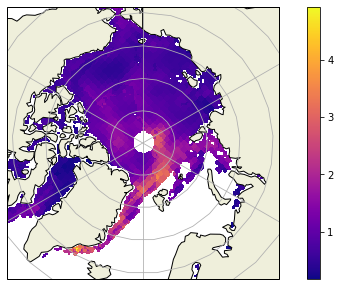

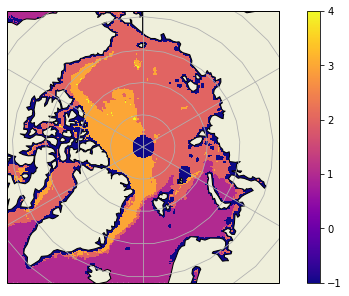

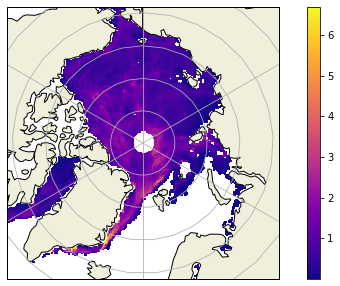

In [29]:
cartoplot(d['lon'],d['lat'],d['NS'][1][:,:])
cartoplot(d['lon'],d['lat'],d['type'][1][:,:])
cartoplot(d['lon'],d['lat'],d['SM'][1][:,:])